In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import scipy as sp
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns
plt.rcParams["figure.dpi"] = 300

: 

In [106]:
df = pd.read_csv('data.csv', delimiter=';')
df.columns = df.columns.str.lstrip()

# get unique values of the target column
df['Race'].unique()
# map "Other" value to number 5
df[df['Race'] == " Other"] = 5
df["Race"].unique()

array(['2', '1', '4', '3', 5], dtype=object)

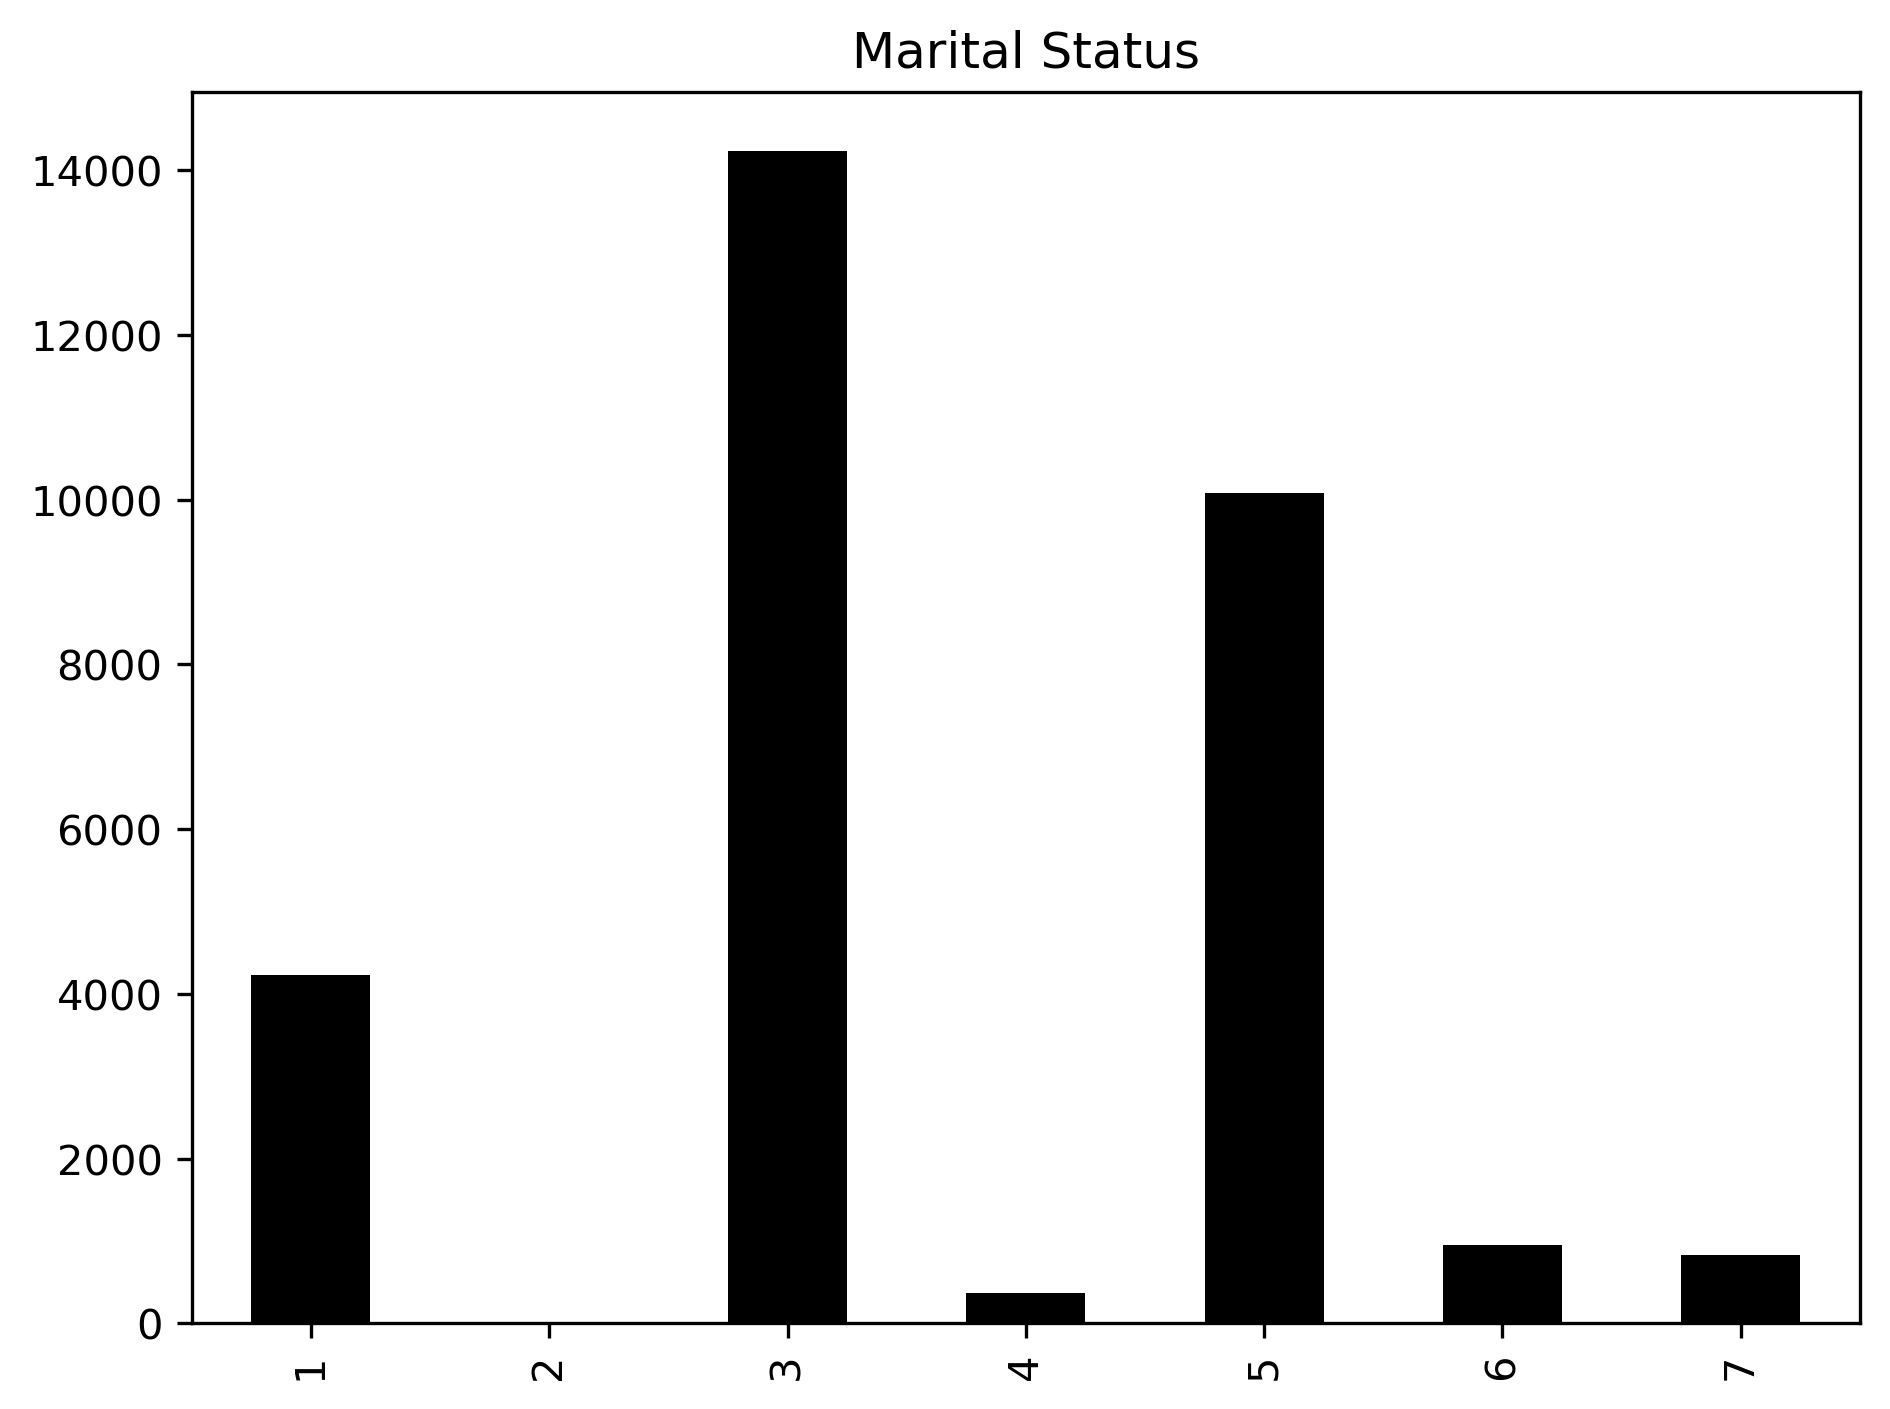

In [109]:

# map non-numerical values to NaN values
df = df.apply(pd.to_numeric, errors='coerce')
# drop rows with NaN values
df = df.dropna()


# strip left spaces from column names
df.columns = df.columns.str.lstrip()
df.head()
y = df["Marital Status"]
y.value_counts().sort_index().plot(kind='bar', color='black', title="Marital Status")
# save figure above
plt.tight_layout()
plt.savefig("/Users/carlosperello/Desktop/claudia/figs/marital_status_bar.png")


In [36]:
df = (df - df.mean()) / df.std()
df.head()

,Age,Workclass,Education,Years of Education,Marital Status,Occupation,Relationship,Race,Sex,Hours Work per Week,Income
0,0.060368,2.538209,-0.334500,1.122432,0.940649,-1.481747,-0.271646,-0.008065,-0.570196,-0.051487,-0.47208
1,0.878803,1.659882,-0.334500,1.122432,-0.396788,-0.734499,-0.891779,-0.008065,-0.570196,-2.227960,-0.47208
2,-0.014035,-0.096773,0.187439,-0.423561,-1.734224,-0.236333,-0.271646,-0.008065,-0.570196,-0.051487,-0.47208
3,1.102013,-0.096773,-2.422256,-1.196557,-0.396788,-0.236333,-0.891779,-1.804045,-0.570196,-0.051487,-0.47208
4,-0.758067,-0.096773,-0.334500,1.122432,-0.396788,0.759997,2.208886,-1.804045,0.995499,-0.051487,-0.47208


In [37]:
X = df.drop(["Marital Status"], axis=1)
X.head()

,Age,Workclass,Education,Years of Education,Occupation,Relationship,Race,Sex,Hours Work per Week,Income
0,0.060368,2.538209,-0.334500,1.122432,-1.481747,-0.271646,-0.008065,-0.570196,-0.051487,-0.47208
1,0.878803,1.659882,-0.334500,1.122432,-0.734499,-0.891779,-0.008065,-0.570196,-2.227960,-0.47208
2,-0.014035,-0.096773,0.187439,-0.423561,-0.236333,-0.271646,-0.008065,-0.570196,-0.051487,-0.47208
3,1.102013,-0.096773,-2.422256,-1.196557,-0.236333,-0.891779,-1.804045,-0.570196,-0.051487,-0.47208
4,-0.758067,-0.096773,-0.334500,1.122432,0.759997,2.208886,-1.804045,0.995499,-0.051487,-0.47208


In [38]:
corrs = {}
p_values ={} 
for col in X.columns:
    corr, p = sp.stats.pearsonr(X[col], y)
    corrs[col] = corr
    p_values[col] = p

p_values


{'Age': 0.0,
 'Workclass': 1.8011848420821862e-05,
 'Education': 2.089473628989828e-08,
 'Years of Education': 8.189969493327565e-38,
 'Occupation': 0.0011829863853453657,
 'Relationship': 0.0,
 'Race': 1.2496907940007147e-11,
 'Sex': 4.337977087813662e-180,
 'Hours Work per Week': 0.0,
 'Income': 5.323237274823121e-287}

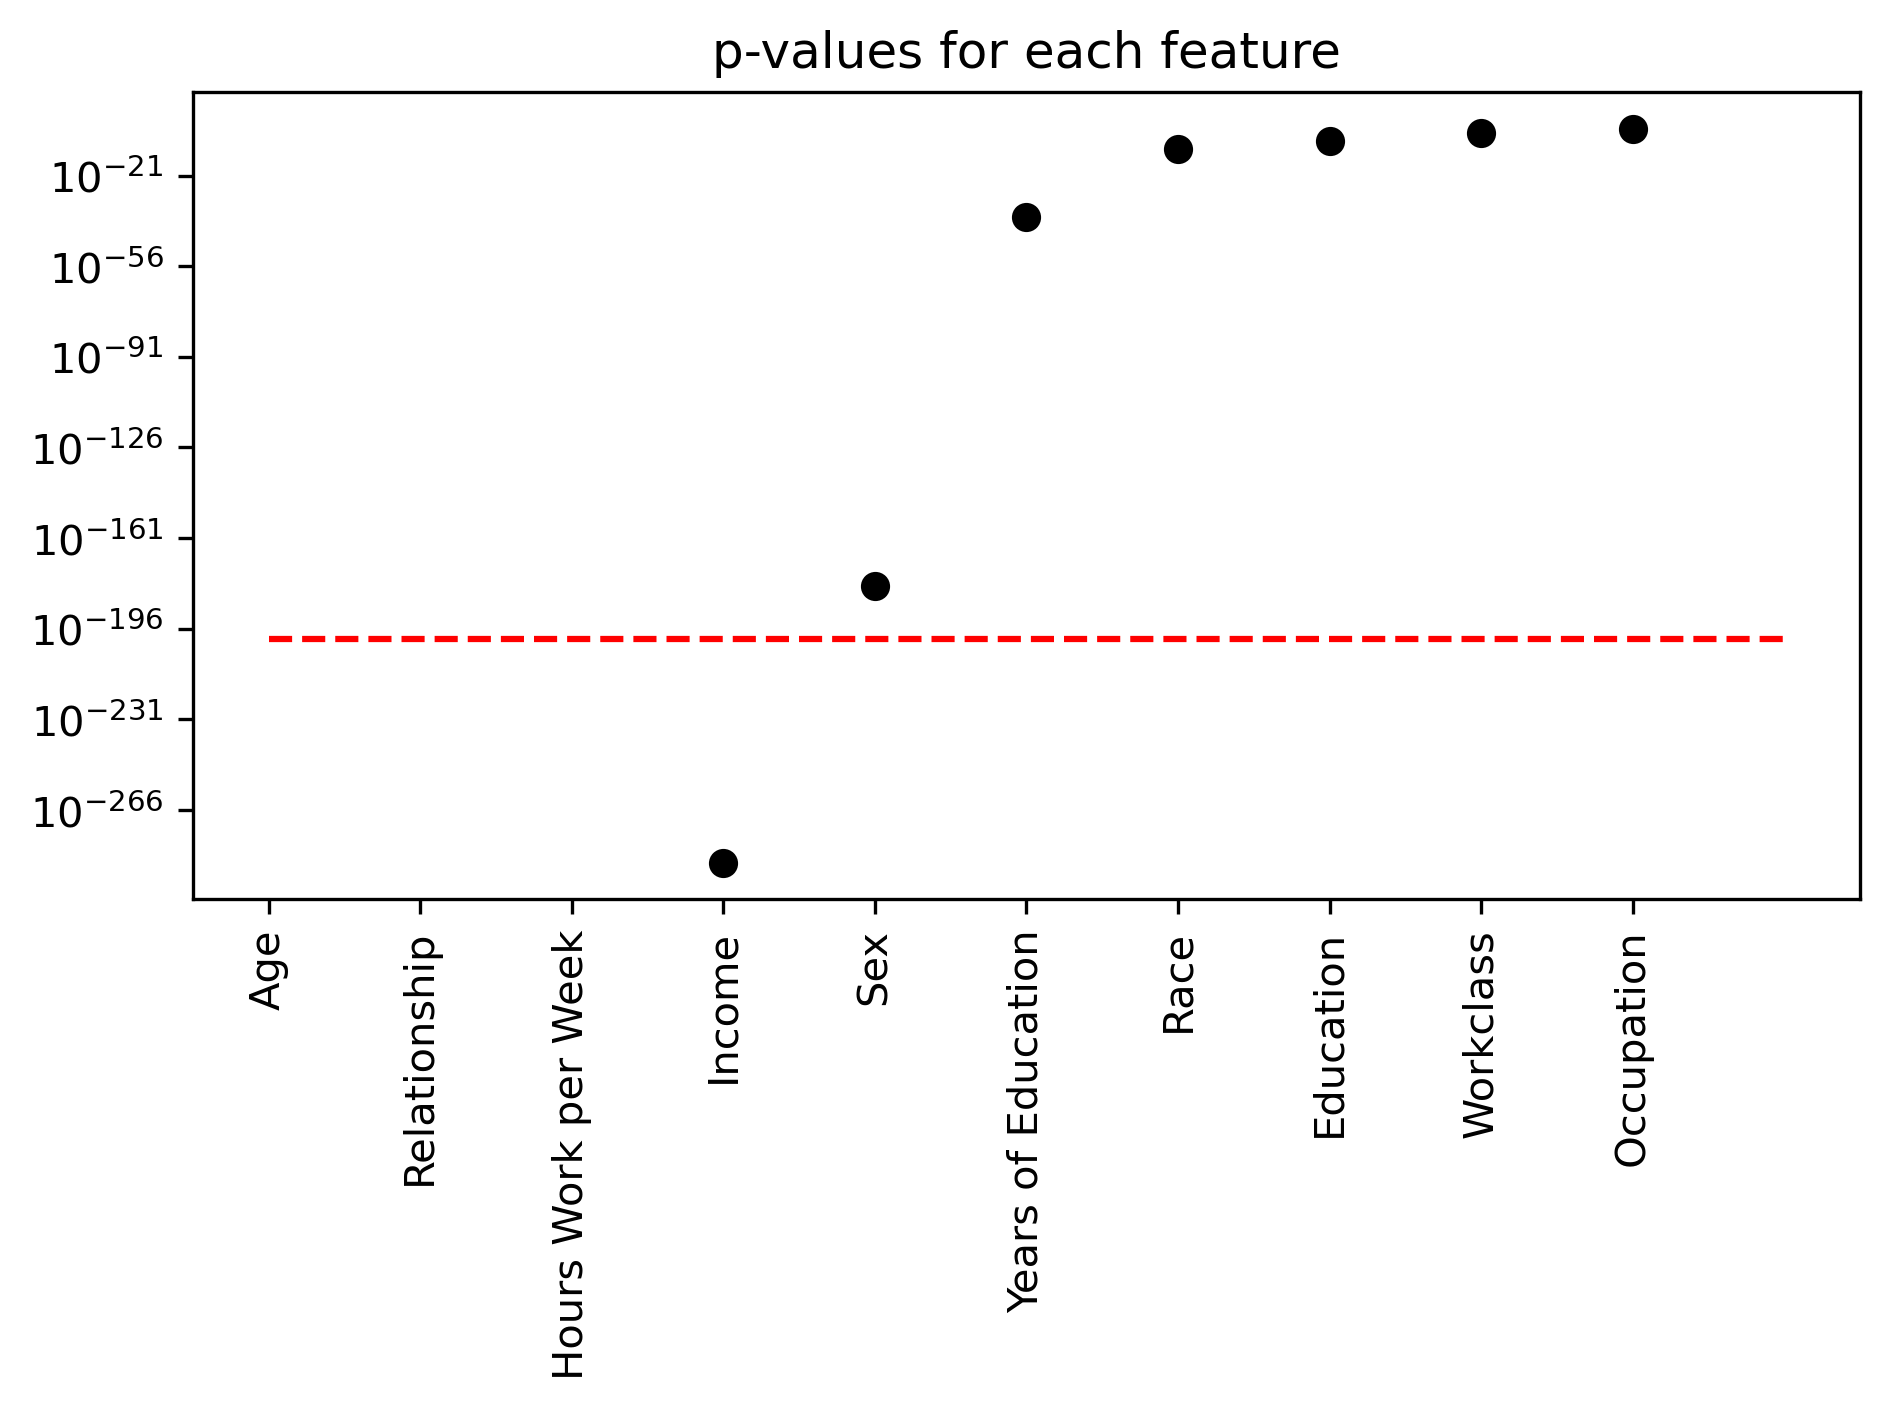

In [115]:
# sort dictionary by values
thresh = 1e-200
sorted_p_values = sorted(p_values.items(), key=lambda x: x[1], reverse=False)
# plot p values for each feature in scatter plot
plt.scatter(range(len(corrs)), [x[1] for x in sorted_p_values], color="black")
plt.xticks(range(len(corrs)), [x[0] for x in sorted_p_values], rotation=90)
plt.yscale("log")
plt.hlines(thresh, 0, len(corrs), color="red", linestyle="dashed")
plt.title("p-values for each feature")
# rotate x labels 45 degrees
plt.tight_layout()
plt.savefig("/Users/carlosperello/Desktop/claudia/figs/p_vals.png")
plt.show()


In [40]:
# keep features with p values < thresh
X = X.drop([x[0] for x in sorted_p_values if x[1] > thresh], axis=1)
X.head()

,Age,Relationship,Hours Work per Week,Income
0,0.060368,-0.271646,-0.051487,-0.47208
1,0.878803,-0.891779,-2.227960,-0.47208
2,-0.014035,-0.271646,-0.051487,-0.47208
3,1.102013,-0.891779,-0.051487,-0.47208
4,-0.758067,2.208886,-0.051487,-0.47208


In [41]:
# split into train, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size=0.2,                  
                                                    shuffle=True,
                                                    random_state=42)


In [42]:
X_train.head()
len(X_train)

19668

In [81]:
# now make an SVM model to predict marital status - we vary the kernel used
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

models = {}
# create a linear SVM classifier
for ker in tqdm(kernels):
    if ker=='linear':
        clf = svm.LinearSVC(max_iter=10000)
        clf.fit(X_train, y_train)
        models[ker] = clf
    else:
        clf = svm.SVC(kernel=ker)
    # train the classifier on the training set
        clf.fit(X_train, y_train)
    # predict the labels of the test set
        models[ker] = clf

100%|██████████| 4/4 [00:57<00:00, 14.33s/it]


In [82]:
y_preds_train = {}
y_preds_val = {}

for kernel, model in tqdm(models.items()):
    y_preds_train[kernel] = model.predict(X_train)
    y_preds_val[kernel] = model.predict(X_val)


100%|██████████| 4/4 [00:42<00:00, 10.72s/it]


In [85]:
# calculate multi-class accuracy
accuracies_val = []
accuracies_train = []
precisions_val = []
precisions_train = []
recalls_val = []
recalls_train = []
for kernel in y_preds_train.keys():
    y_pred_train = y_preds_train[kernel]
    y_pred_val = y_preds_val[kernel]
    accuracies_train.append(accuracy_score(y_train, y_pred_train))
    accuracies_val.append(accuracy_score(y_val, y_pred_val))
    precisions_train.append(precision_score(y_train, y_pred_train, average='macro', zero_division=0))
    precisions_val.append(precision_score(y_val, y_pred_val, average='macro', zero_division=0))
    recalls_train.append(recall_score(y_train, y_pred_train, average='macro', zero_division=0))
    recalls_val.append(recall_score(y_val, y_pred_val, average='macro', zero_division=0))


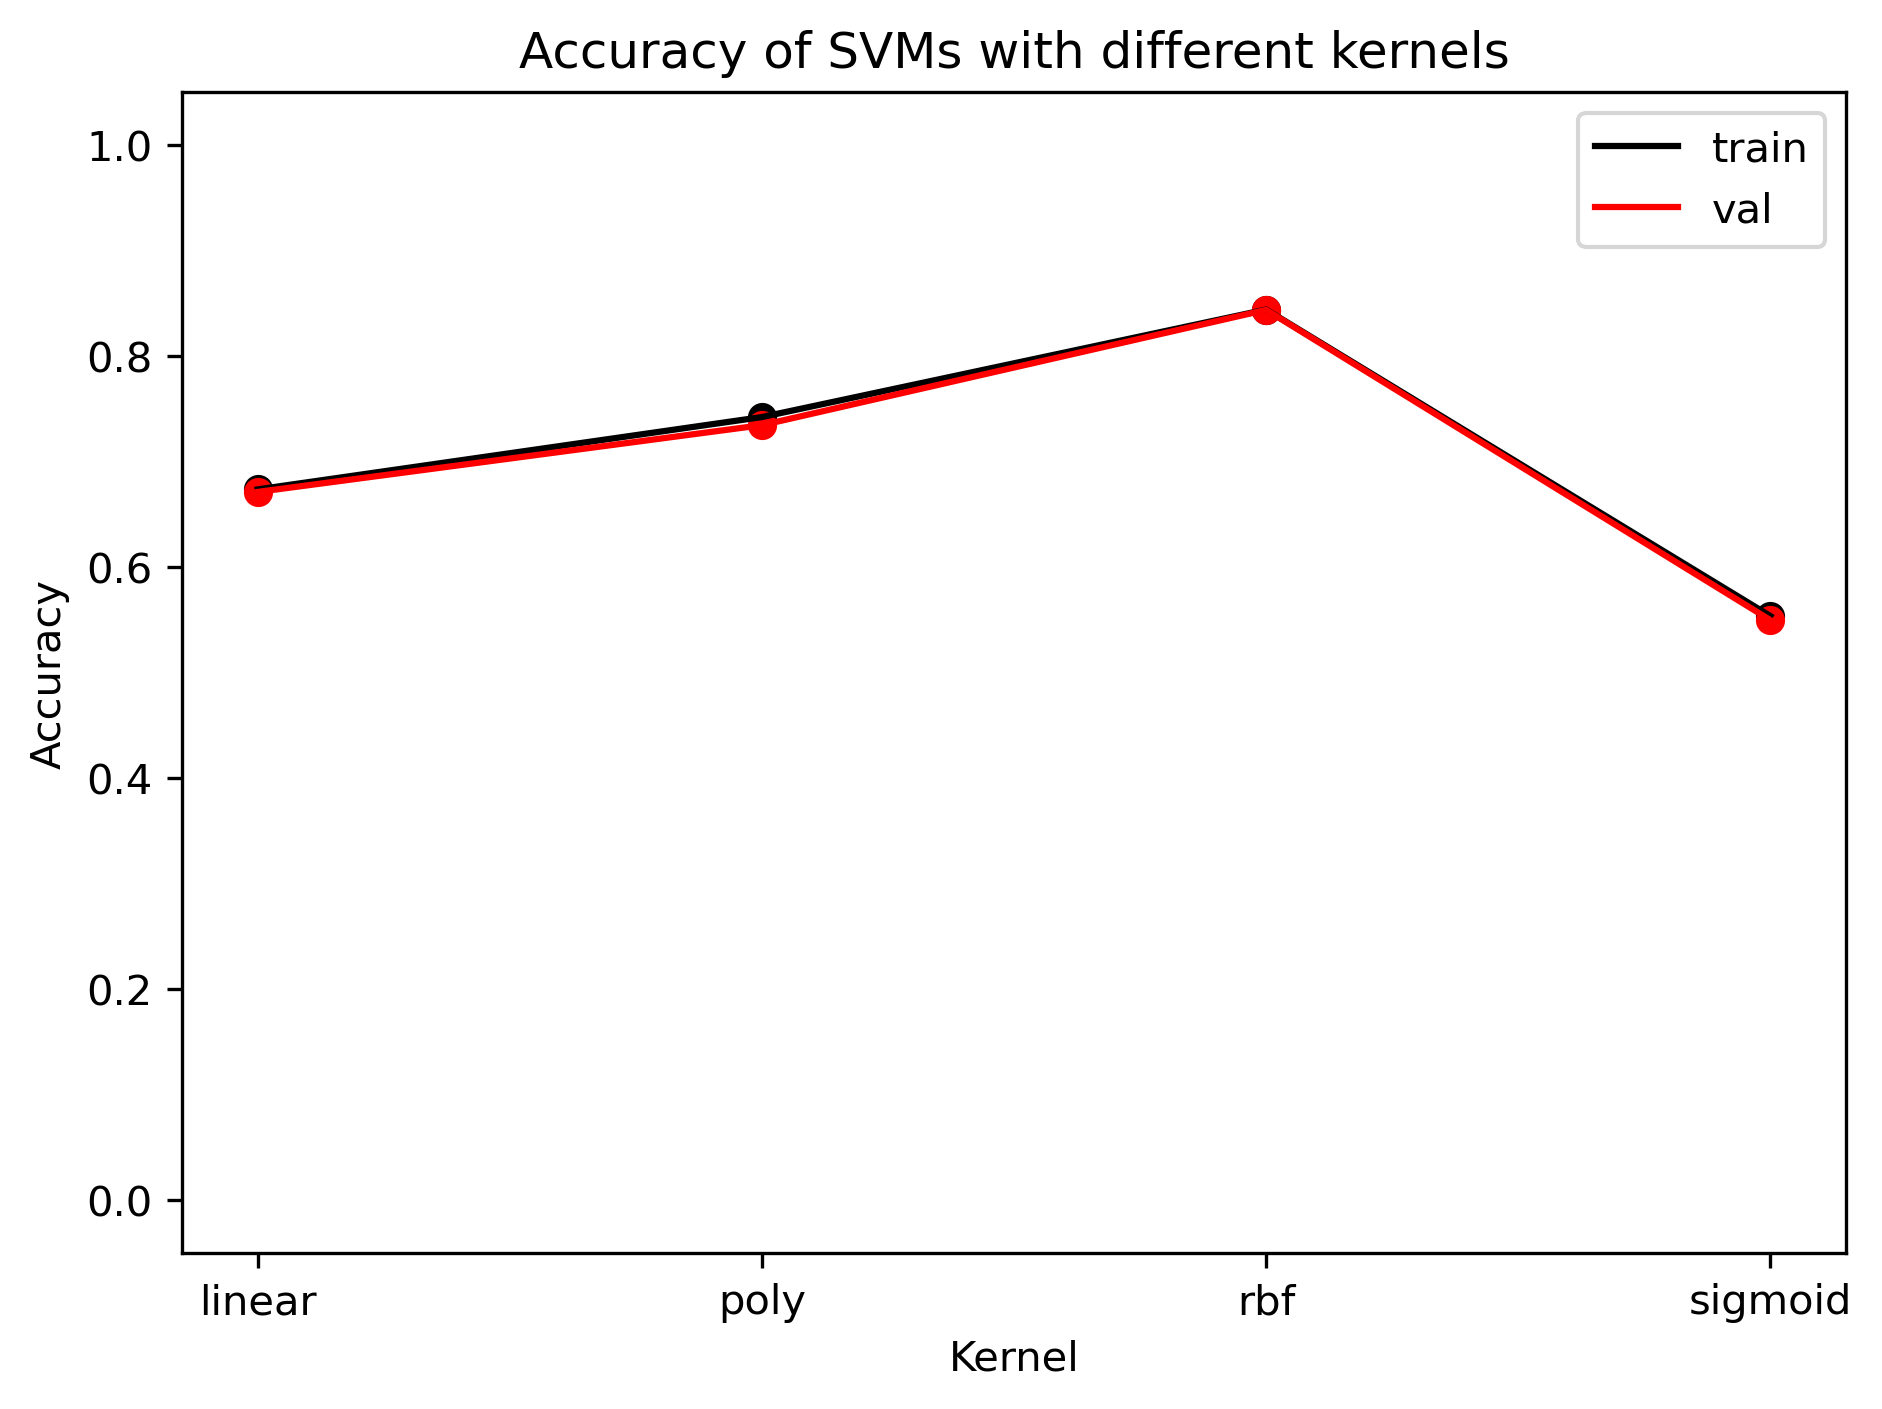

In [103]:
# plot accuracies for each kernel as a line graph
plt.plot(kernels, accuracies_train, color="black", label="train")
plt.scatter(kernels, accuracies_train, color="black")
plt.plot(kernels, accuracies_val, color="red", label="val")
plt.scatter(kernels, accuracies_val, color="red")
plt.legend()
plt.ylim(-0.05, 1.05)
plt.xlabel("Kernel")
plt.ylabel("Accuracy")
plt.title("Accuracy of SVMs with different kernels")
plt.tight_layout()
plt.savefig("/Users/carlosperello/Desktop/claudia/figs/Accuracy_kernels.png")
plt.show()


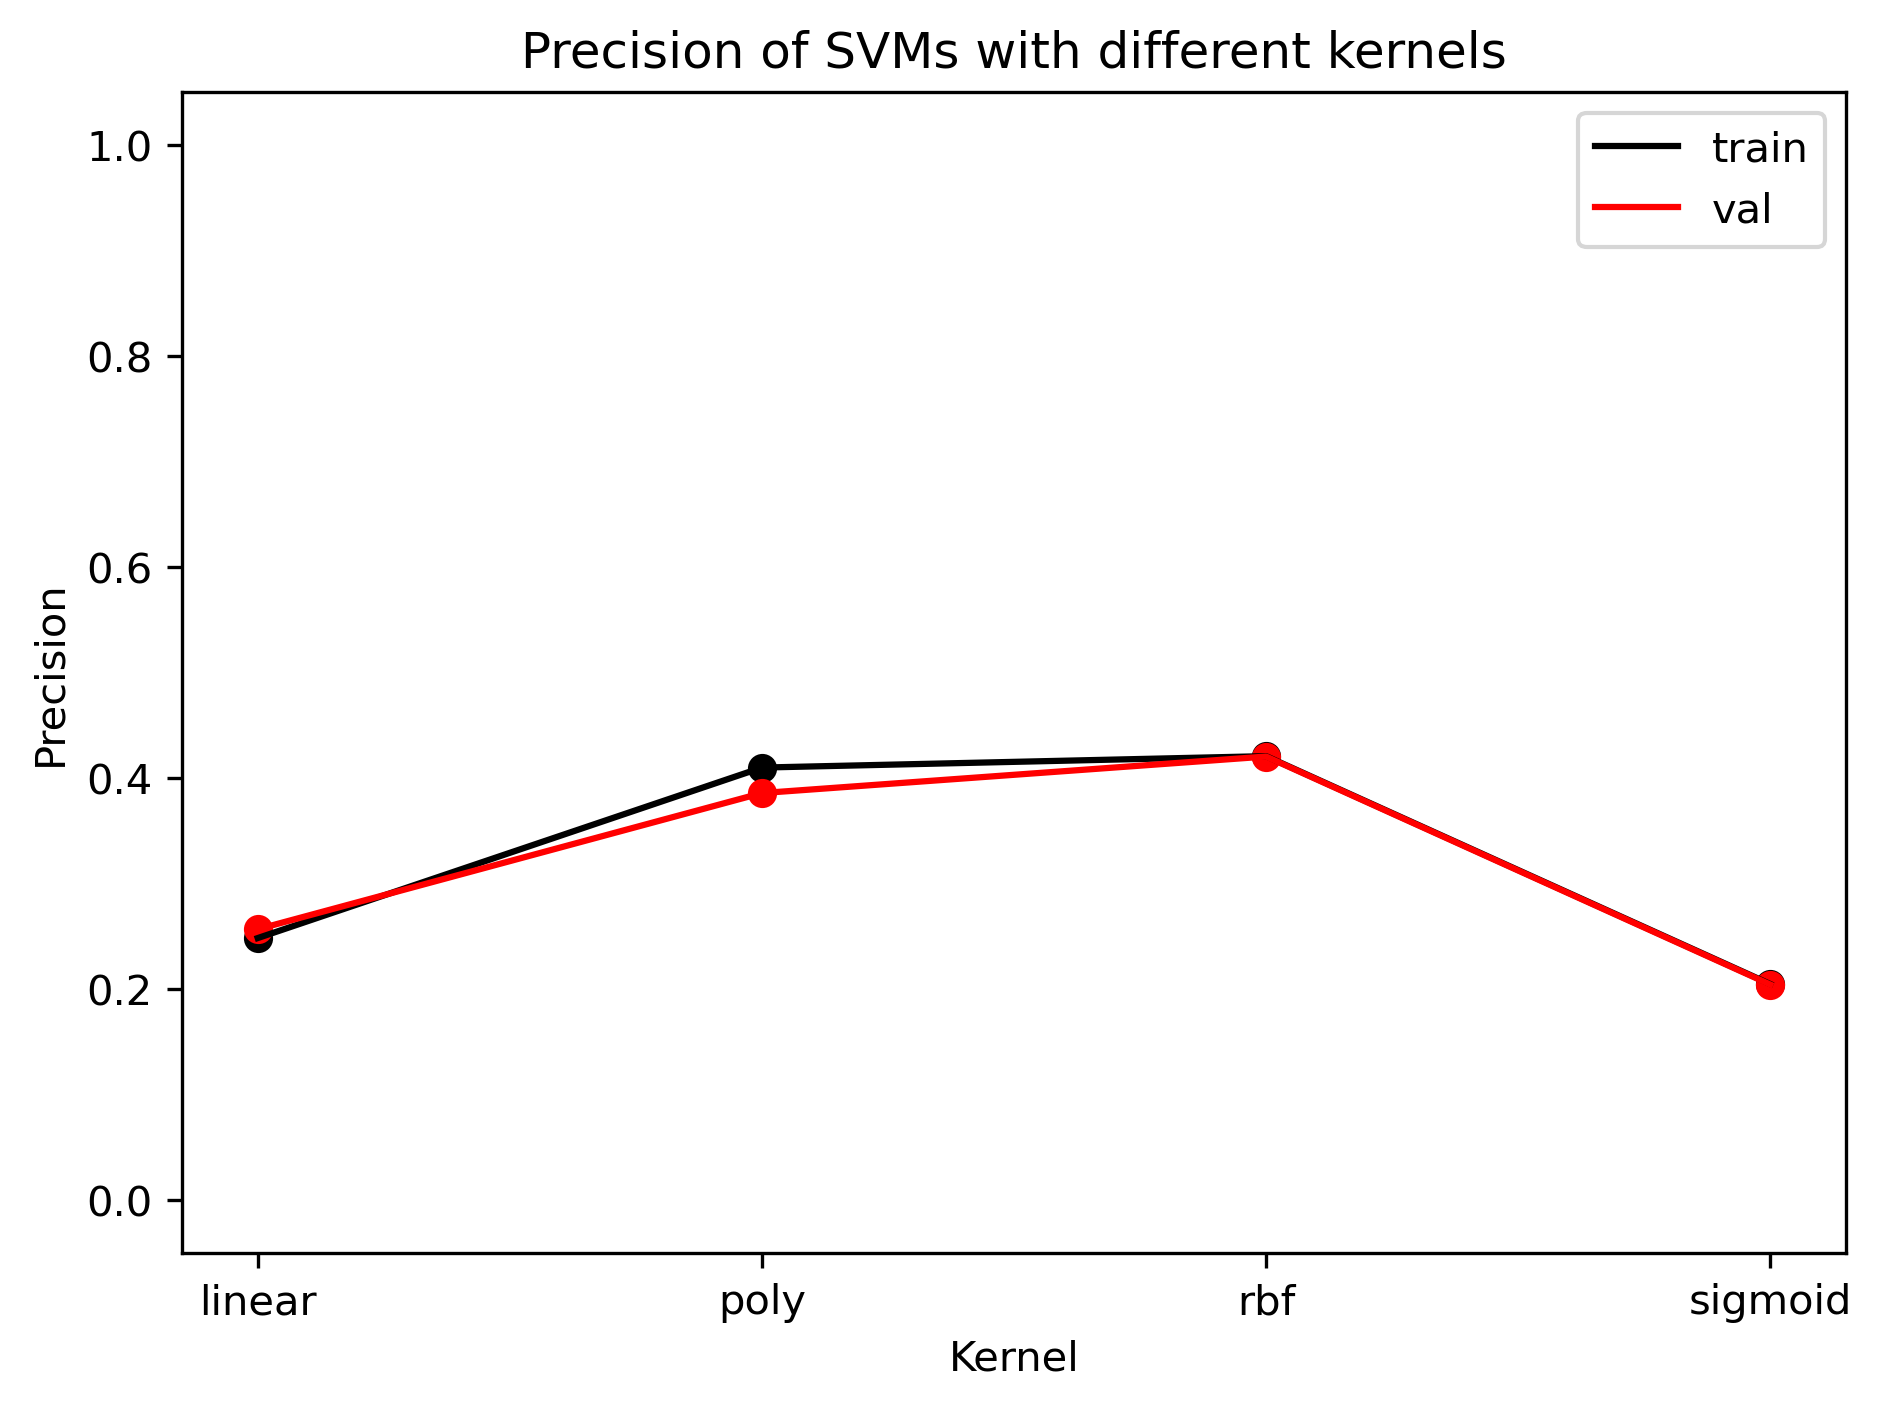

In [102]:
plt.plot(kernels, precisions_train, color="black", label="train")
plt.scatter(kernels, precisions_train, color="black")
plt.plot(kernels, precisions_val, color="red", label="val")
plt.scatter(kernels, precisions_val, color="red")
plt.legend()
plt.ylim(-0.05, 1.05)
plt.xlabel("Kernel")
plt.ylabel("Precision")
plt.title("Precision of SVMs with different kernels")
plt.tight_layout()
plt.savefig("/Users/carlosperello/Desktop/claudia/figs/Precision_kernels.png")
plt.show()


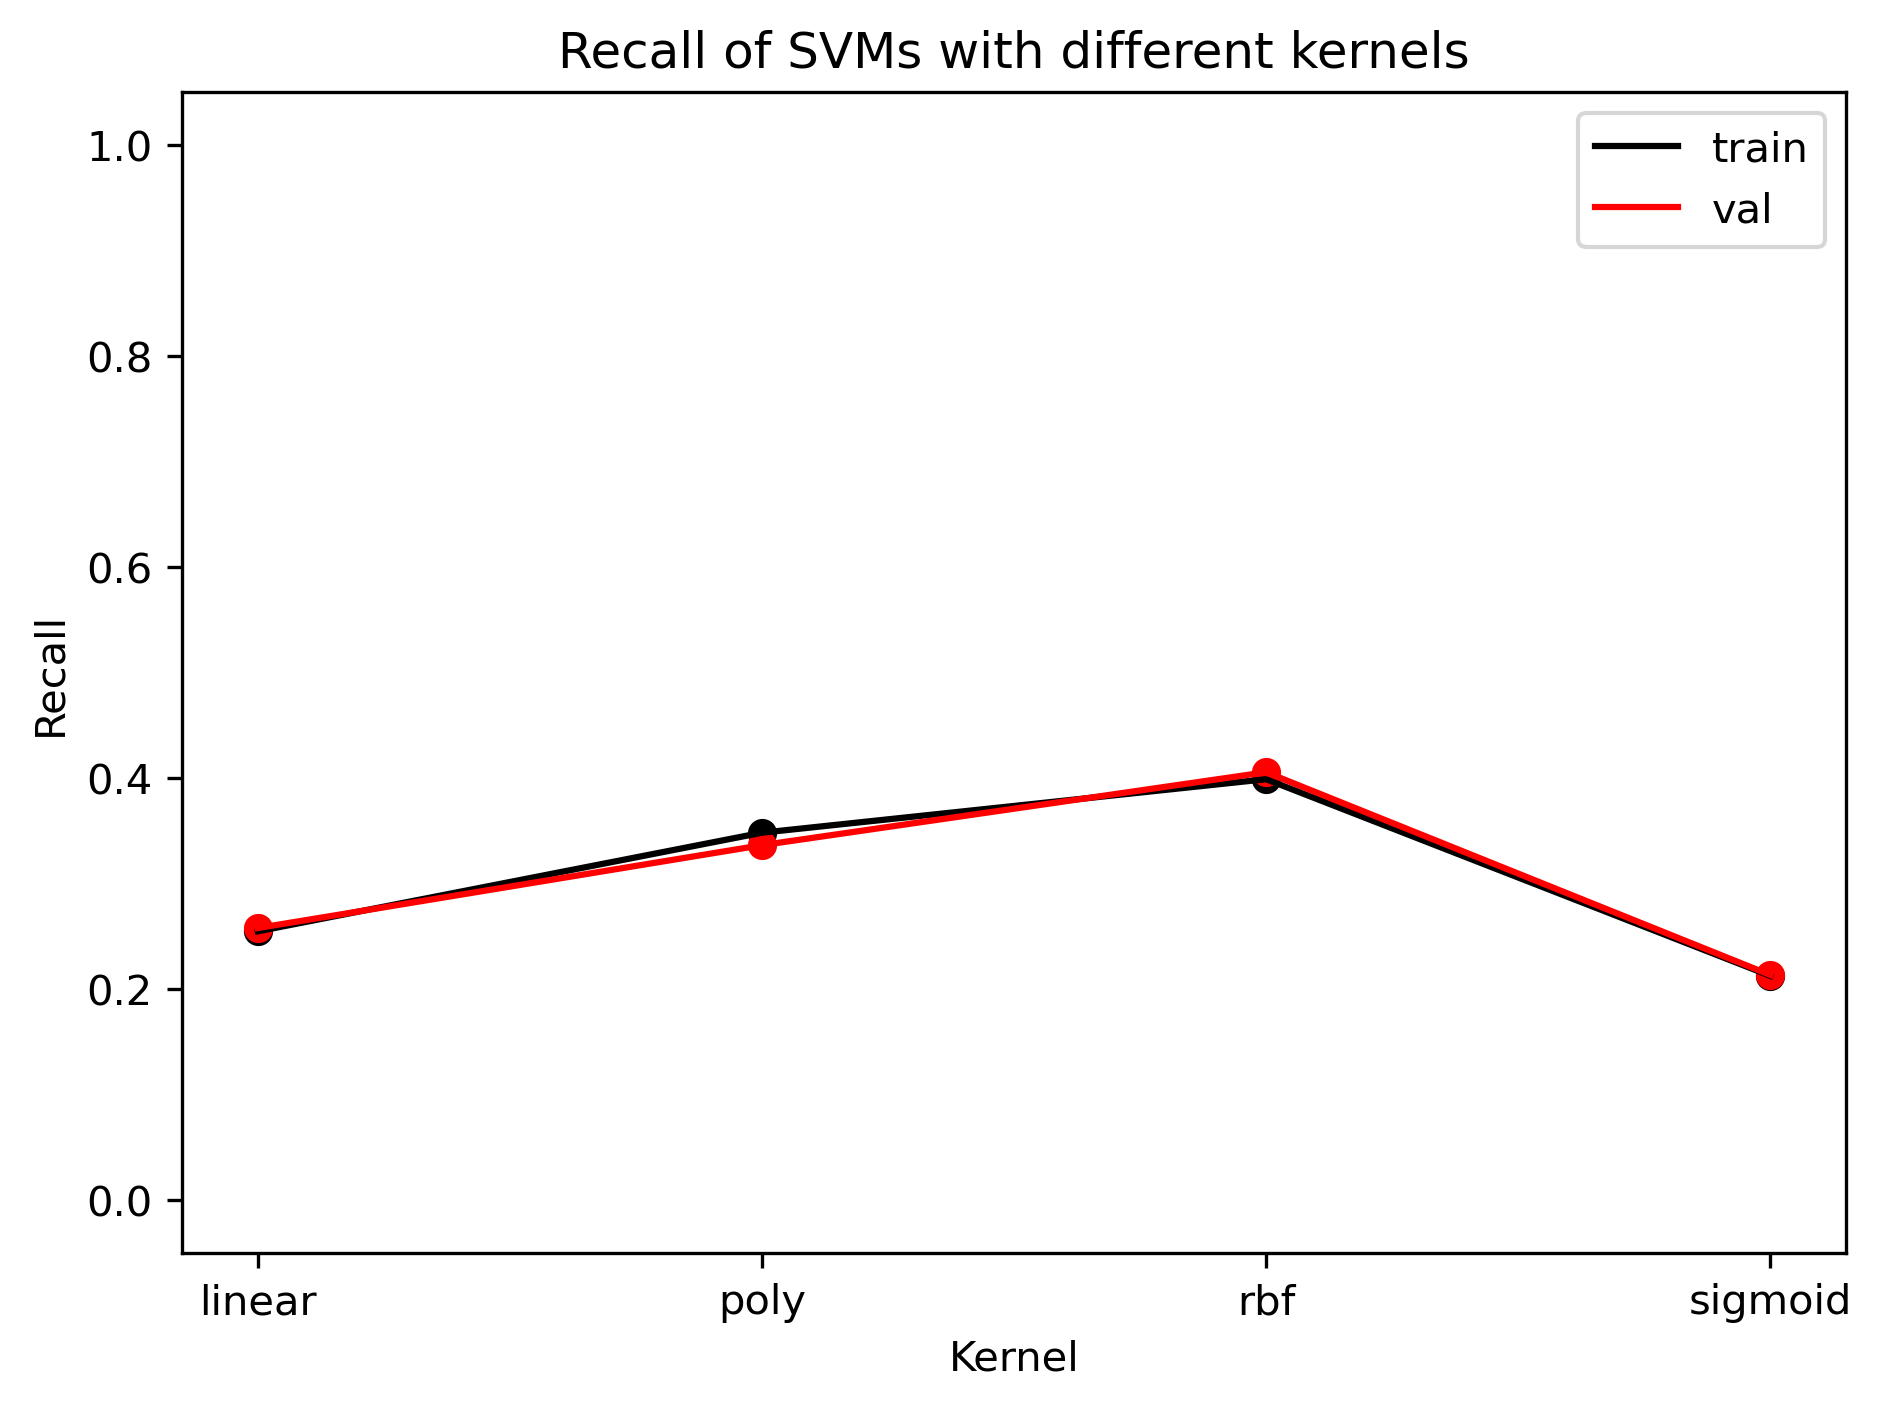

In [101]:
plt.plot(kernels, recalls_train, color="black", label="train")
plt.scatter(kernels, recalls_train, color="black")
plt.plot(kernels, recalls_val, color="red", label="val")
plt.scatter(kernels, recalls_val, color="red")
plt.legend()
plt.ylim(-0.05, 1.05)
plt.xlabel("Kernel")
plt.ylabel("Recall")
plt.title("Recall of SVMs with different kernels")
plt.tight_layout()
plt.savefig("/Users/carlosperello/Desktop/claudia/figs/Recall_kernels.png")

plt.show()


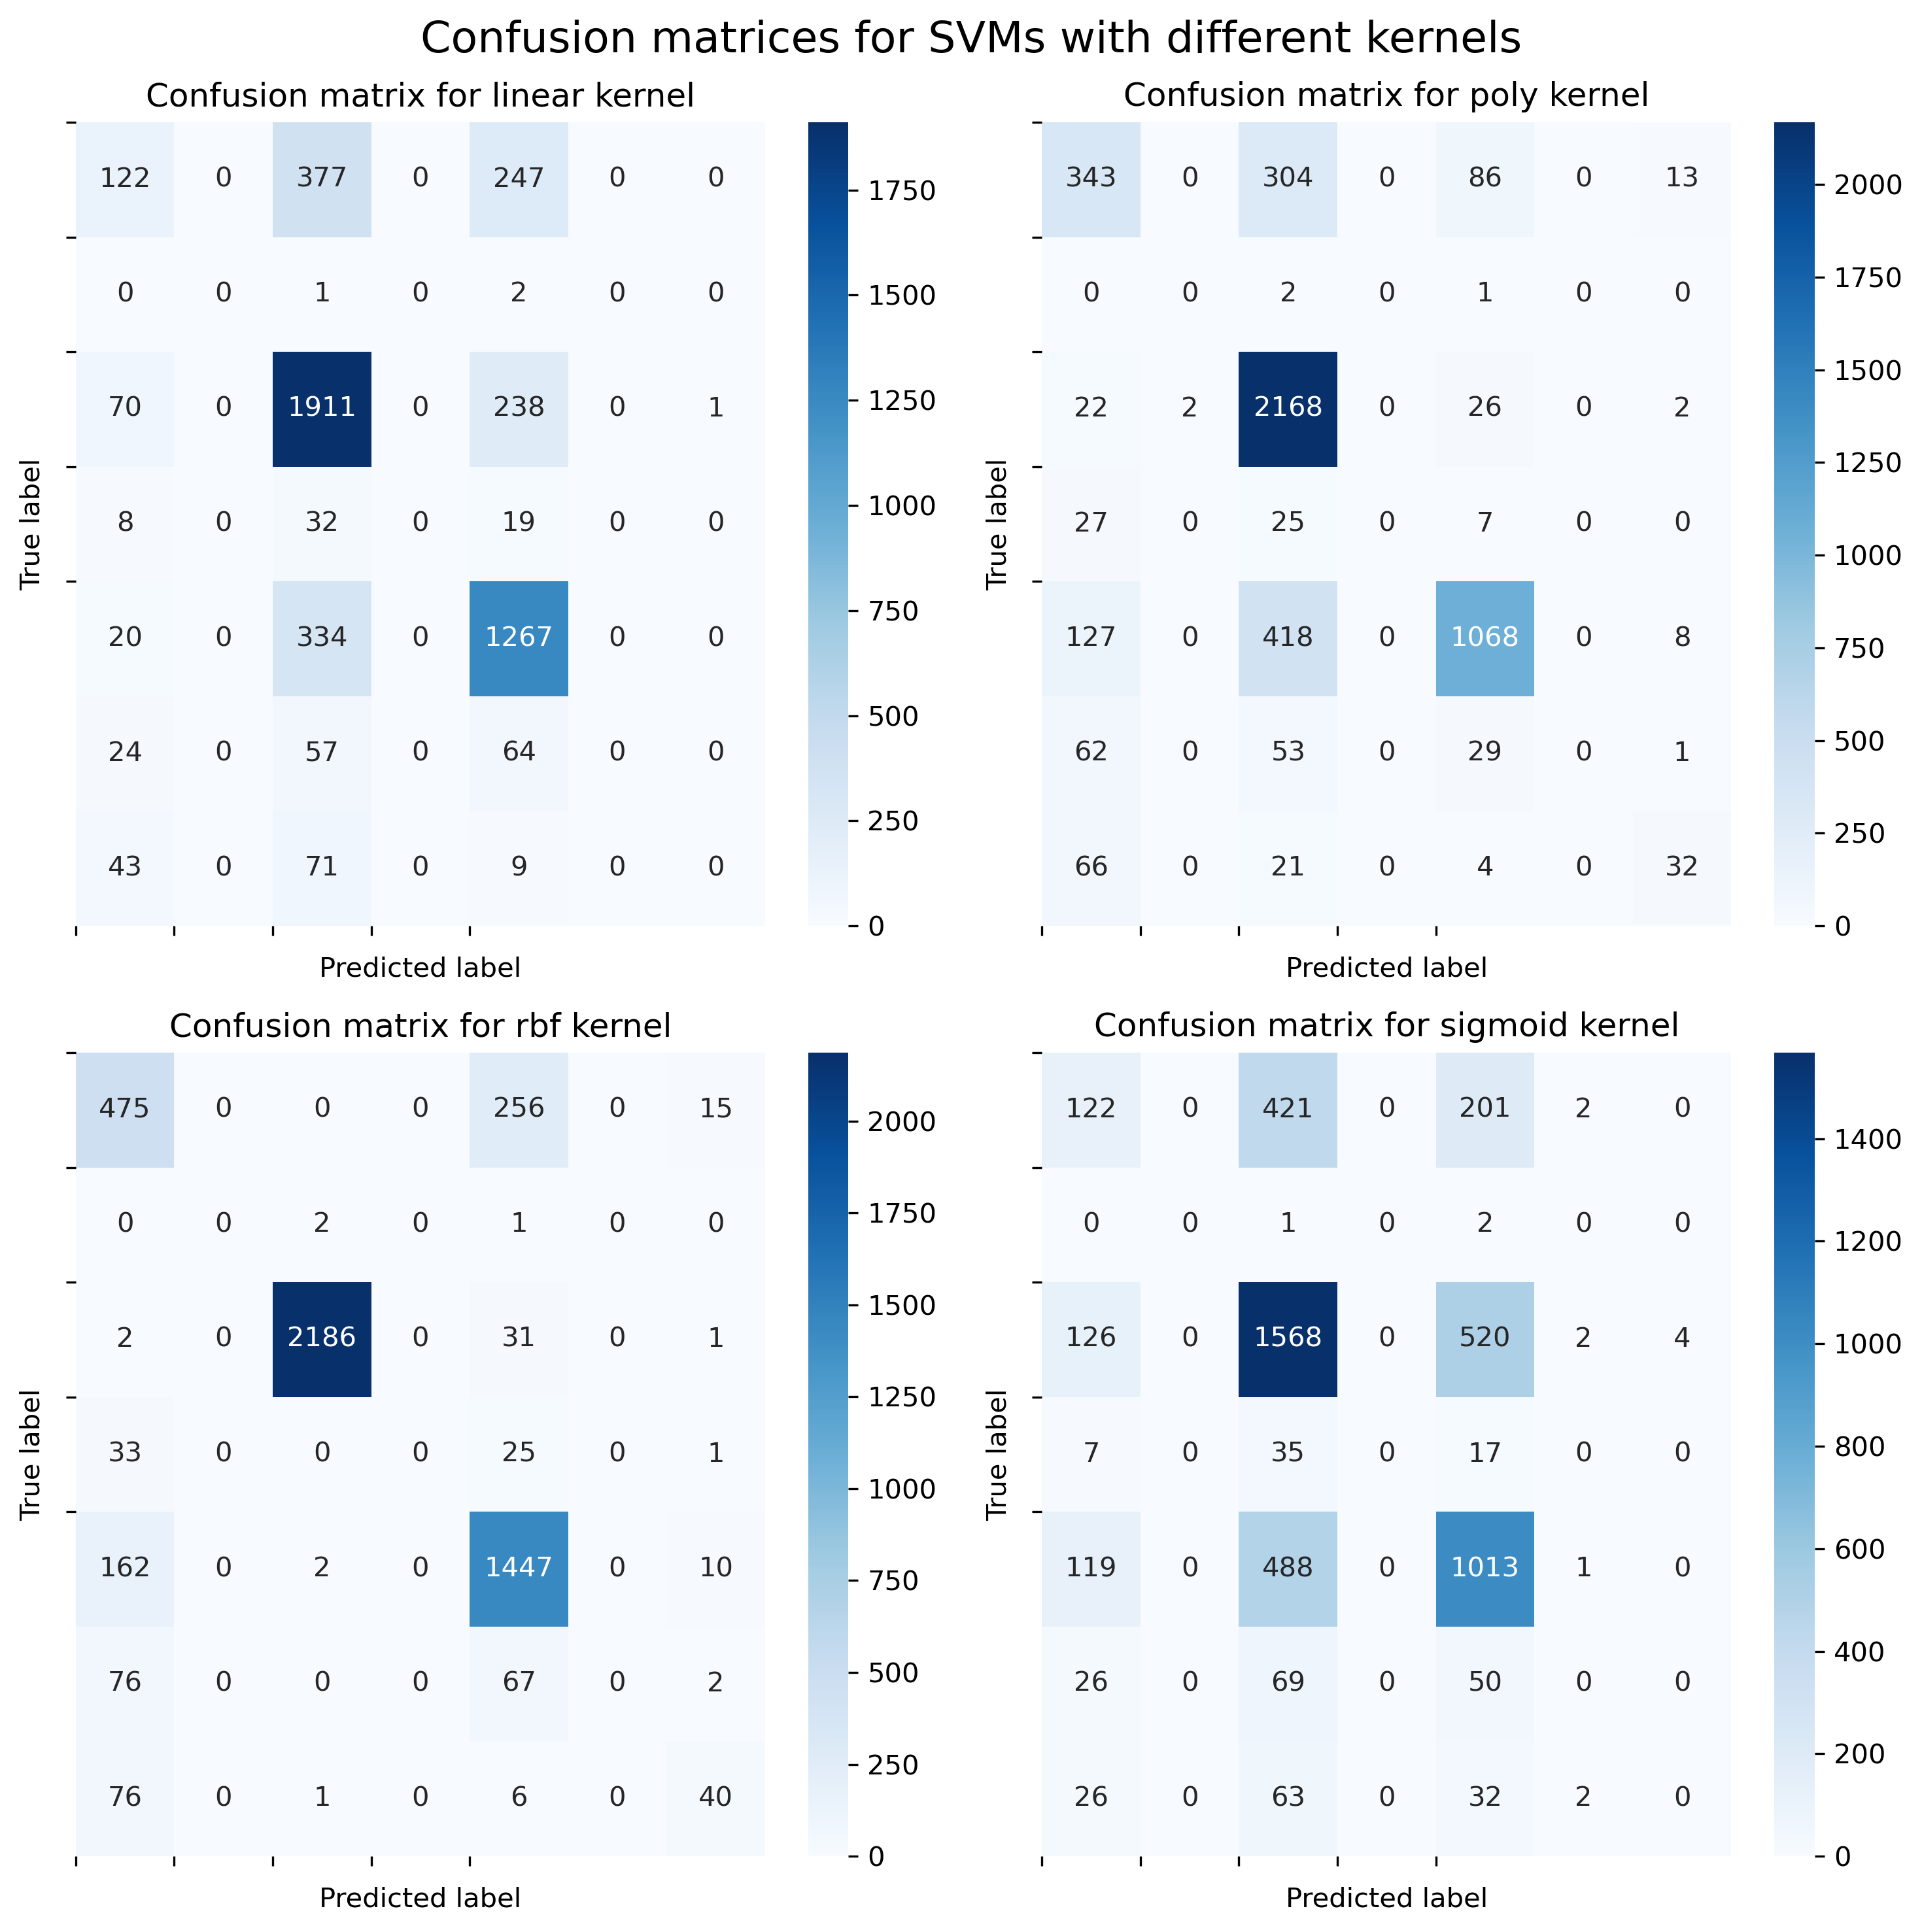

In [100]:
# compute multi-class confusion matrix
confusion_matrices = []
for kernel, y_pred in y_preds_val.items():
    confusion_matrices.append(confusion_matrix(y_val, y_pred))

# plot confusion matrices for each kernel
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    sns.heatmap(confusion_matrices[i], ax=ax, annot=True, fmt='d',cmap="Blues")
    ax.set_title(f"Confusion matrix for {kernels[i]} kernel")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks(range(5))
    ax.set_yticks(range(5))
    # show class numbers on the axes
    
plt.suptitle("Confusion matrices for SVMs with different kernels", fontsize=16)
plt.tight_layout()
plt.savefig("/Users/carlosperello/Desktop/claudia/figs/confusion_matrix.png")
plt.show()

In [75]:
# validation to select the best c value for the rbf kernel

# create a list of c values to try
c_values = [0.01, 0.1, 1, 10, 100, 1000, 10000]
# create a dictionary to store the accuracies for each c value
train_accuracies = {}
val_accuracies = {}
train_precisions = {}
val_precisions = {}
train_recalls = {}
val_recalls = {}
# create a dictionary to store the models for each c value
models_c = {}
# for loop below:
for c in tqdm(c_values):
    # create a classifier with the current c value
    clf = svm.SVC(kernel='rbf', C=c)
    # train the classifier on the training set
    clf.fit(X_train, y_train)
    # predict the labels of the test set
    train_y_pred = clf.predict(X_train)
    val_y_pred = clf.predict(X_val)
    # store the accuracy of the classifier with the current c value
    train_accuracies[c] = accuracy_score(y_train, train_y_pred)
    val_accuracies[c] = accuracy_score(y_val, val_y_pred)

    train_precisions[c] = precision_score(y_train, train_y_pred, average='macro', zero_division=0)
    val_precisions[c] = precision_score(y_val, val_y_pred, average='macro', zero_division=0)

    train_recalls[c] = recall_score(y_train, train_y_pred, average='macro', zero_division=0)
    val_recalls[c] = recall_score(y_val, val_y_pred, average='macro', zero_division=0)
    
    # store the classifier with the current c value
    models[c] = clf


100%|██████████| 7/7 [18:01<00:00, 154.43s/it]


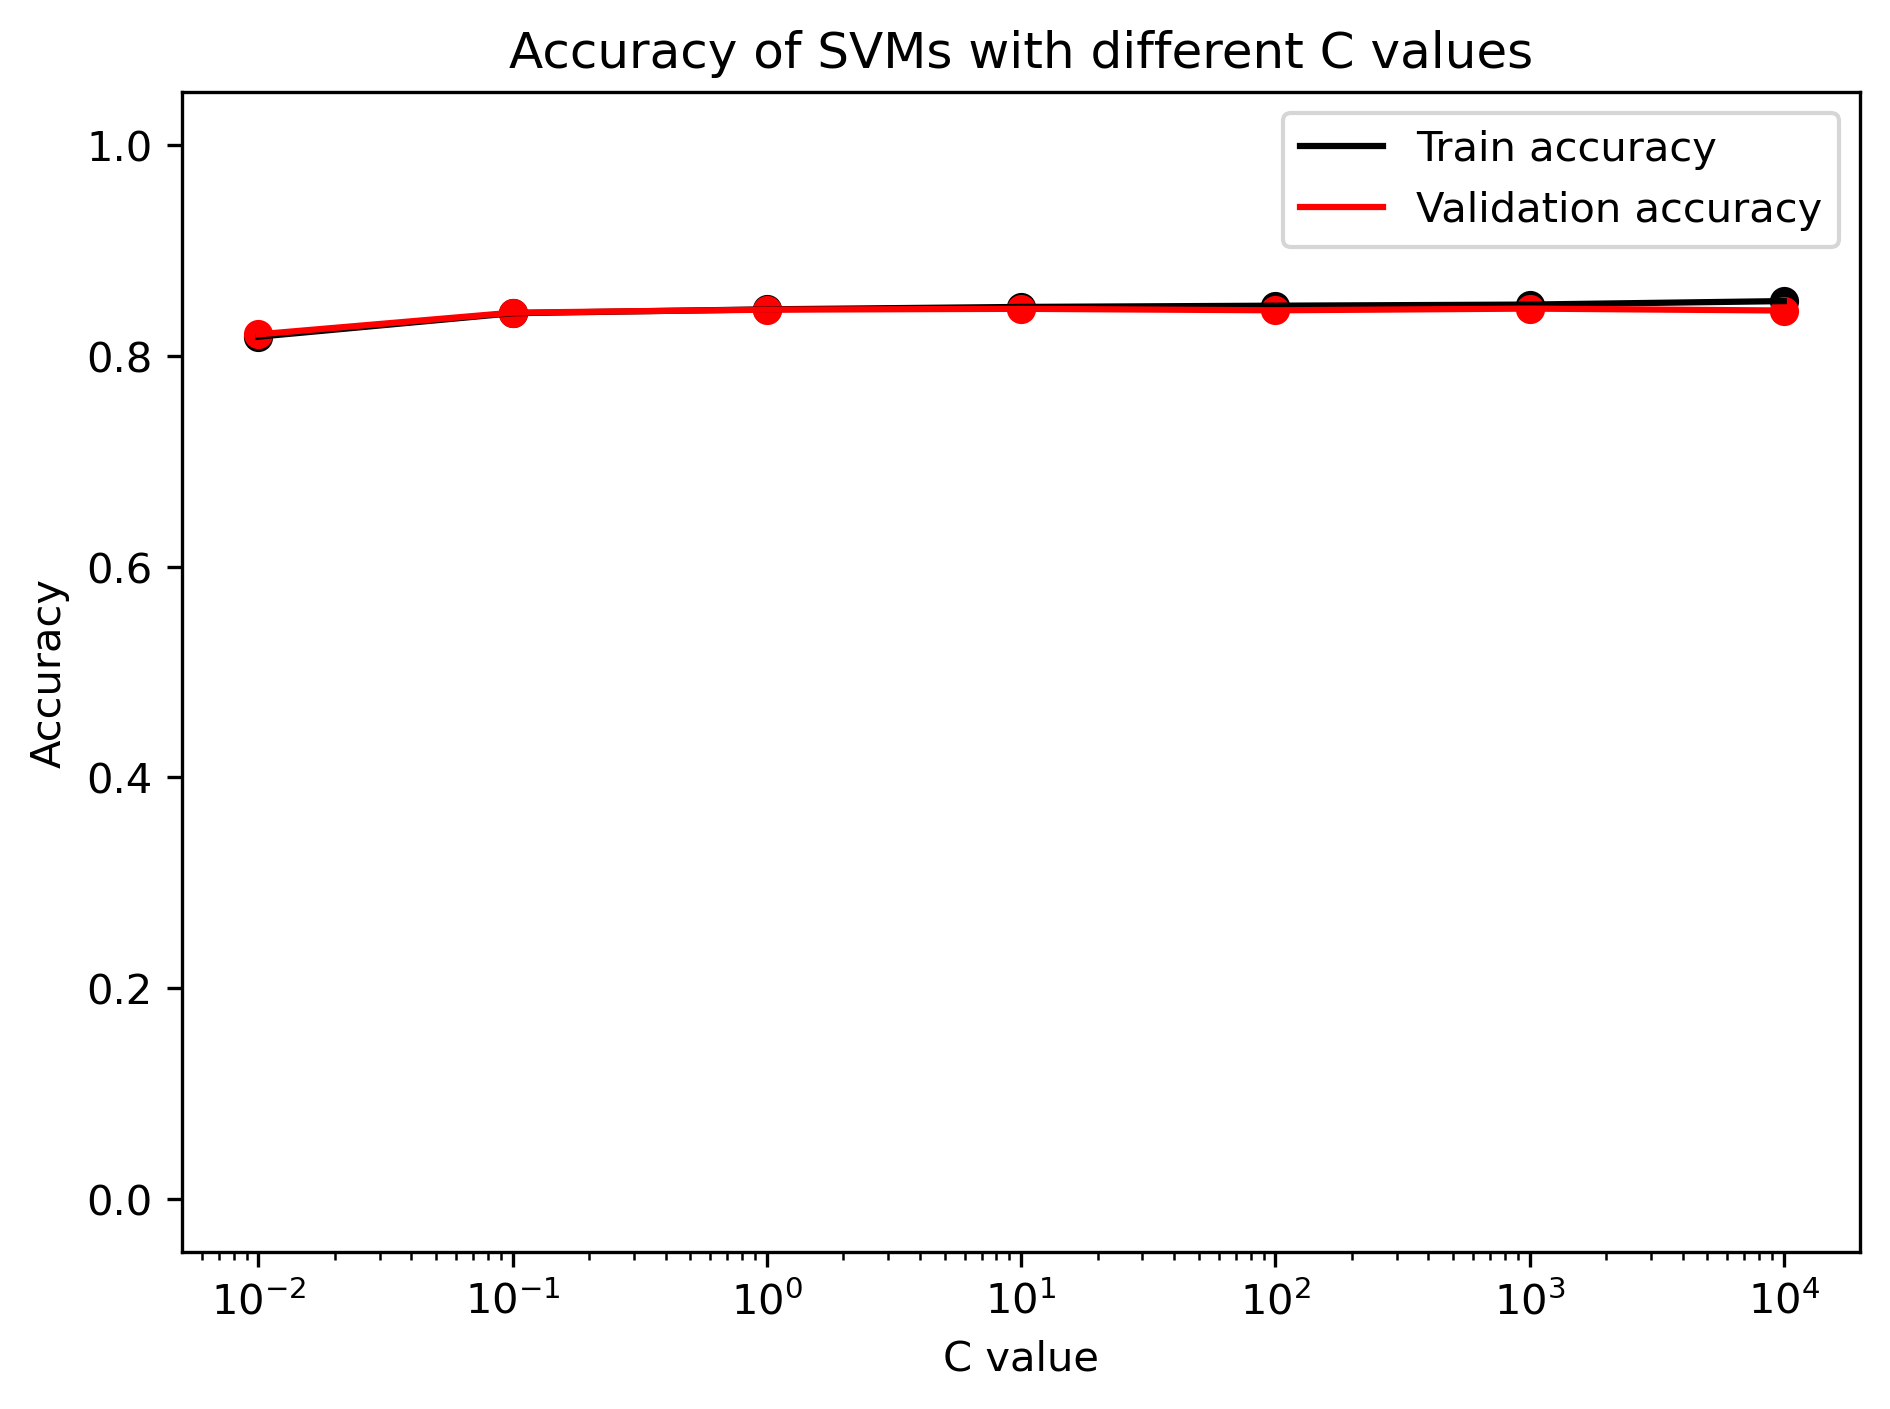

In [99]:
# plot accuracies for each c value as a line graph
plt.plot(c_values, list(train_accuracies.values()), color="black", label = "Train accuracy")
plt.scatter(c_values, list(train_accuracies.values()), color="black")
plt.plot(c_values, list(val_accuracies.values()), color="red", label = "Validation accuracy")
plt.scatter(c_values, list(val_accuracies.values()), color="red")
plt.ylim(-0.05, 1.05)
plt.xscale("log")
plt.xlabel("C value")
plt.ylabel("Accuracy")
plt.title("Accuracy of SVMs with different C values")
plt.legend()
plt.tight_layout()
plt.savefig("/Users/carlosperello/Desktop/claudia/figs/Accuracy_c_values.png")
plt.show()

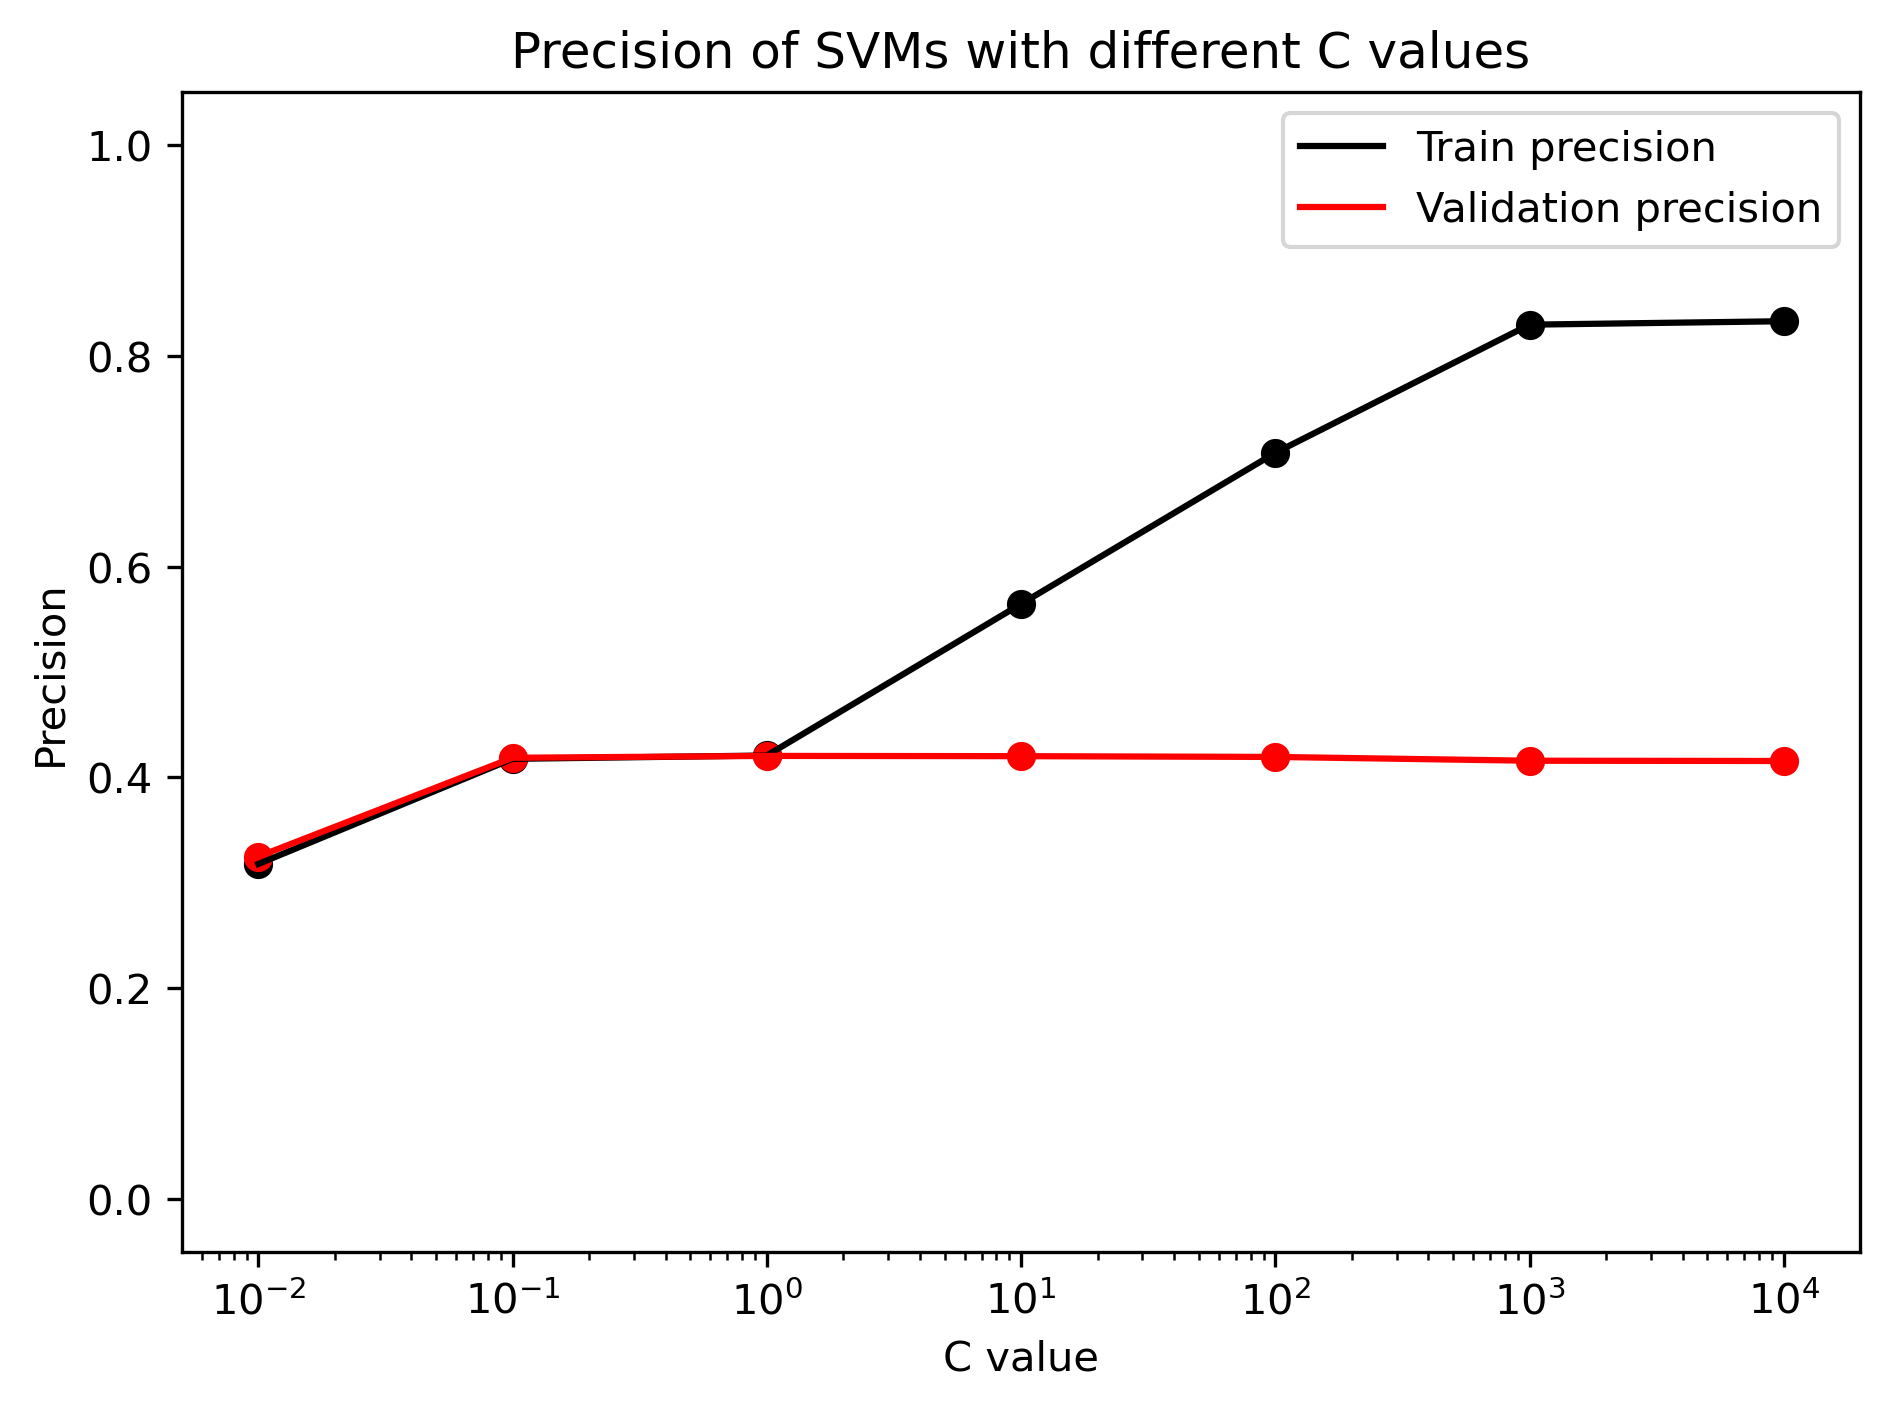

In [98]:
plt.plot(c_values, list(train_precisions.values()), color="black", label = "Train precision")
plt.scatter(c_values, list(train_precisions.values()), color="black")
plt.plot(c_values, list(val_precisions.values()), color="red", label = "Validation precision")
plt.scatter(c_values, list(val_precisions.values()), color="red")
plt.ylim(-0.05, 1.05)
plt.xscale("log")
plt.xlabel("C value")
plt.ylabel("Precision")
plt.title("Precision of SVMs with different C values")
plt.legend()
plt.tight_layout()
plt.savefig("/Users/carlosperello/Desktop/claudia/figs/Precision_c_values.png")
plt.show()


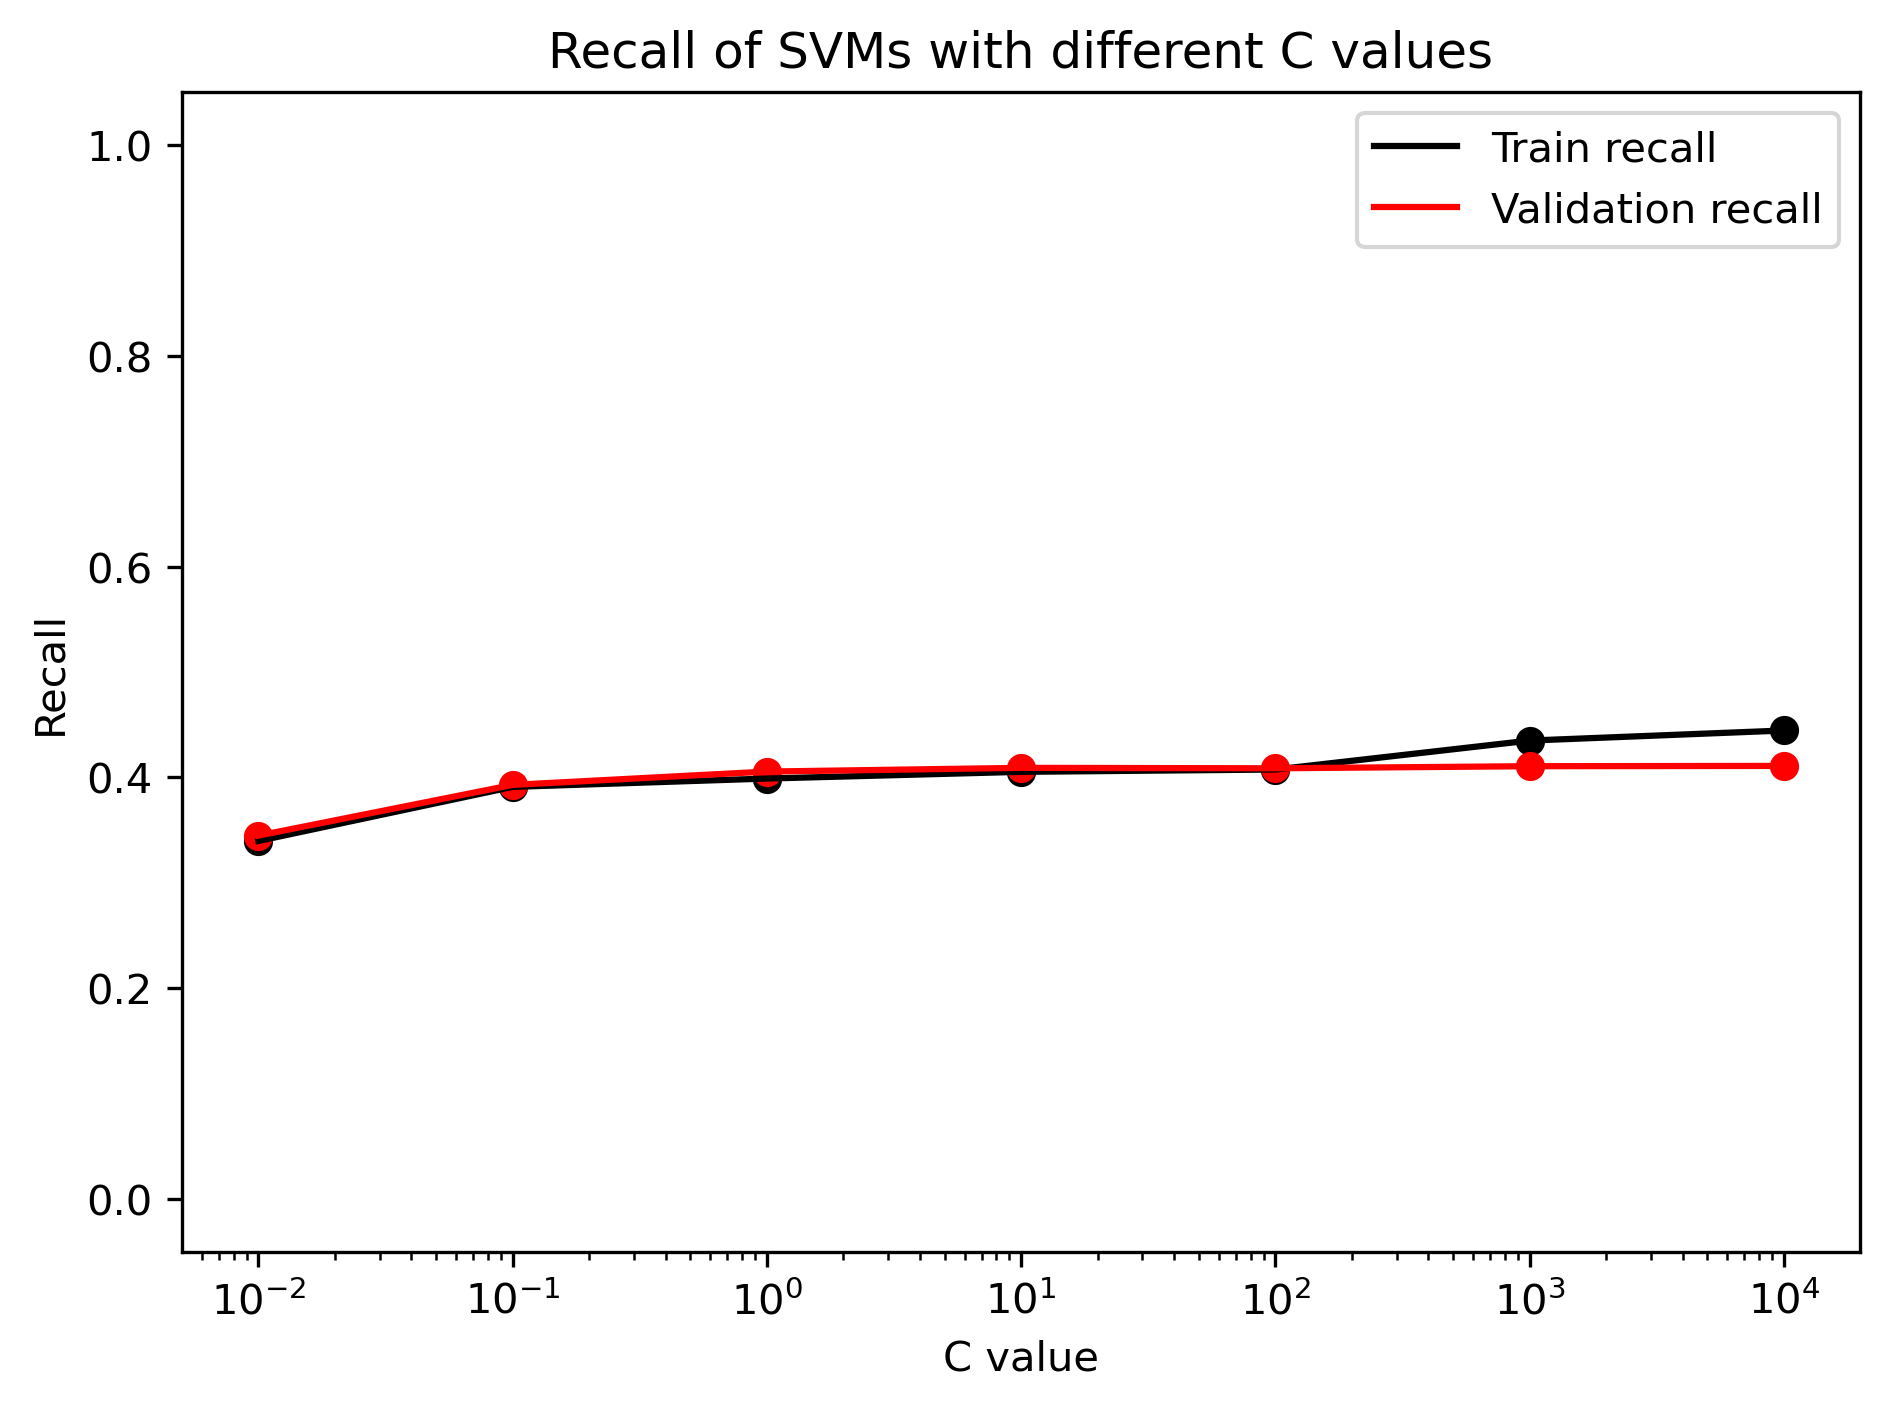

In [97]:
plt.plot(c_values, list(train_recalls.values()), color="black", label = "Train recall")
plt.scatter(c_values, list(train_recalls.values()), color="black")
plt.plot(c_values, list(val_recalls.values()), color="red", label = "Validation recall")
plt.scatter(c_values, list(val_recalls.values()), color="red")
plt.ylim(-0.05, 1.05)
plt.xscale("log")
plt.xlabel("C value")
plt.ylabel("Recall")
plt.title("Recall of SVMs with different C values")
plt.legend()
plt.tight_layout()
plt.savefig("/Users/carlosperello/Desktop/claudia/figs/Recall_c_values.png")
plt.show()